In [1]:
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import warnings
import gc
import copy
from itertools import product
from IPython.display import display
import datetime

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 1000)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
gongqi = pd.read_csv('gongqi.csv', encoding='utf-8-sig', index_col=0)

In [3]:
# ['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', '产品组名称', '产品组代码', 
# '创建日期', 'year', 'month', 'week', 'day', 'weekday', '订单数量', '订单金额', '物料描述', 
# '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型']
df = pd.read_csv('gongqi.csv', encoding='utf-8-sig',
                 usecols=['物料编号', '基本计量单位', 'year', 'month', 'week', 'day', '创建日期',
                          '订单数量', '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况'])
print(len(df['物料编号'].unique()))
print(df.columns)

# 存在订单金额为0的订单，三包单或者赠送订单，不好处理
# 物料类别有冲突这里只取一种类别，后续让业务解决冲突
# 先不管这些问题，不做筛选，一起来整体看看

20311
Index(['物料编号', '基本计量单位', '创建日期', 'year', 'month', 'week', 'day', '订单数量',
       '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况'],
      dtype='object')


In [ ]:
# 考虑引入期的新配件和停产期的老配件，这一部分怎么处理？
# 除了上面的以外就是生产期的配件
# 这些信息业务可以给出？

In [ ]:
# 对于生产期的配件，高/低频，高/低价值，量的大小？
# 对于不同业务类别的配件？

In [4]:
# 构造包含完整月份的订单数据，没有的月份订单数量补0
# 无物料类别信息等业务信息的，补未知
def struct_full_month_df(df):
    full_month_df = pd.DataFrame(product(df['物料编号'].unique(), 
                         np.sort(df['year'].unique()),
                         np.sort(df['month'].unique())),
                columns=['物料编号', 'year', 'month'])
    temp1 = df.groupby(['物料编号', 'year', 'month'], as_index=False)['订单数量'].agg({'月订单数量':'sum'})
    temp2 = df.groupby(['物料类别', '物料编号'], as_index=False).count()
    temp3 = df.groupby(['基本计量单位', '物料编号'], as_index=False).count()
    temp4 = df.groupby(['是否进口件', '物料编号'], as_index=False).count()
    temp5 = df.groupby(['周期（天）下计划后的交货周期', '物料编号'], as_index=False).count()
    temp6 = df.groupby(['在产情况', '物料编号'], as_index=False).count()
    full_month_df = pd.merge(full_month_df, temp1, on=['物料编号', 'year', 'month'], how='left')
    full_month_df = pd.merge(full_month_df, temp2[['物料类别', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp3[['基本计量单位', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp4[['是否进口件', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp5[['周期（天）下计划后的交货周期', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp6[['在产情况', '物料编号']], on=['物料编号'], how='left')
    full_month_df['月订单数量'].fillna(0, inplace=True)
    full_month_df.fillna('未知', inplace=True)
    return full_month_df

def plot_monthly(data, ylabel='月订单数量', title='各年份各类配件需求总量随月份变化图'):
    
    plt.figure(figsize=(12, 4))
    x = data['date']
    y = data[ylabel]
#     plt.plot(x, y)
    plt.bar(x, y, width=10)
    plt.xticks(fontsize=20)    
    plt.yticks(fontsize=30) 
    plt.xlabel('月份', fontsize=30)    
    plt.ylabel('需求', fontsize=30)
    plt.title(title, fontsize=30)
    plt.grid()
    plt.gcf().autofmt_xdate() # 自动旋转日期标记
    plt.show()

# 思路1：计算需求间隔平均值
# 注意计算间隔的方式，算序列前面的0，不算序列后面的0，只要没到非0值就一直计数，到非0值就重新计数
# 定义是否合理，如果序列后面有很多0呢？？？？后续应该在序列最后补一个非0值来计算间隔，也有问题？？？？
# 平均间隔单独看有各种问题，需要考虑结合0值的比例，平均值等信息
# def interval_mean(input_endog):
    
#     input_series = np.asarray(input_endog)
# #     input_length = len(input_series)
#     nzd = np.where(input_series != 0)[0] # find location of non-zero demand
# #     z = input_series[nzd] # demand
#     x = np.concatenate([[nzd[0]], np.diff(nzd)]) # intervals
#     # input_series = [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
#     # nzd = [ 5  6  8 11 16]
#     # x = [5 1 2 3 5]
#     p = np.mean(x)
#     if list(nzd) == []: # 序列里全是0，此时，均值为0，方差为0，间隔为nan
#         p = np.nan
#     if list(nzd) == [0]: # 序列开头非0，后面全是0，此时，间隔给一个大值，20？
#         p = 20
#     # 输出求间隔平均值
#     return p

# 思路2：计算需求间隔平均值
# 考虑几个特殊情况，如果不处理，对平均间隔计算有较大影响
def interval_mean(input_endog):
    
    input_series = np.asarray(input_endog)
    # 考虑序列全0的情况，定义间隔长度为序列长度
    if np.isin(input_series, [0]).all():
        return len(input_series)
    # 考虑序列后面一个或多个0结尾的情况，补一个0来定义间隔长度
    if input_series[-1]==0:
        input_series = np.append(input_series, 1)
    nzd = np.where(input_series != 0)[0] # find location of non-zero demand
    if nzd[0]!=0:
        x = np.concatenate([[nzd[0]], np.diff(nzd)]) # intervals
    else:
        # 考虑序列开头为非0的情况，按照上面的代码会计算出间隔为0，这里针对这种情况特殊处理
        x = np.diff(nzd)
    p = np.mean(x)
    # 输出求间隔平均值
    return p

In [5]:
matrl_full = struct_full_month_df(df)
print(len(matrl_full))

487464


In [6]:
# 计算每个物料的各种统计量，以及保留相关业务属性（物料类别、计量单位等）
matrl_stats = matrl_full.groupby('物料编号', as_index=False)['月订单数量'].agg({'单配件月需求均值':'mean'})
matrl_stats['单配件月需求最大值'] = matrl_full.groupby('物料编号')['月订单数量'].max().values
matrl_stats['单配件月需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月需求变异系数'] = matrl_stats['单配件月需求标准差'] / matrl_stats['单配件月需求均值']
matrl_stats['需求平均间隔'] = matrl_full.groupby('物料编号')['月订单数量'].apply(interval_mean).values

id_class = matrl_full.groupby(['物料编号','物料类别'],as_index=False).count()[['物料编号','物料类别']]
matrl_stats = pd.merge(matrl_stats, id_class, on='物料编号', how='left')

# id_measuring = matrl_full.groupby(['物料编号','基本计量单位'],as_index=False).count()[['物料编号','基本计量单位']]
# matrl_stats = pd.merge(matrl_stats, id_measuring, on='物料编号', how='left')

# 把月订单数量的0值转换为空值，方便统计非0统计量
matrl_full.loc[matrl_full['月订单数量']==0, '月订单数量'] = np.nan
matrl_stats['单配件月非0需求均值'] = matrl_full.groupby('物料编号')['月订单数量'].mean().values
matrl_stats['单配件月非0需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月非0需求变异系数'] = matrl_stats['单配件月非0需求标准差'] / matrl_stats['单配件月非0需求均值']

matrl_stats['单月0需求比例'] = 1 - matrl_full.groupby('物料编号')['月订单数量'].count().values / 24
# 统计完以后，把月订单数量的空值重新填0
matrl_full['月订单数量'].fillna(0, inplace=True)

In [7]:
print(len(matrl_stats))
matrl_stats.head()

20311


,物料编号,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,物料类别,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
0,004700027A265016Z,0.041667,1.0,0.204124,4.898979,12.0,未知,1.0,NaN,NaN,0.958333
1,004700027A265116Z,0.041667,1.0,0.204124,4.898979,12.0,电器件类,1.0,NaN,NaN,0.958333
2,004700027A265118Z,0.250000,3.0,0.675664,2.702656,4.8,电器件类,1.5,1.0,0.666667,0.833333
3,004700027A265126Z,0.083333,1.0,0.282330,3.387958,8.0,电器件类,1.0,0.0,0.000000,0.916667
4,004700027A270001Z,0.083333,1.0,0.282330,3.387958,8.0,电器件类,1.0,0.0,0.000000,0.916667


In [9]:
matrl_stats['物料类别'].value_counts()

一般结构件类            4361
管和接头类             2395
电器件类              1975
未知                1688
橡塑尼龙类              984
传动件传动操纵类           842
国标件                776
泵和阀类               750
轴承类                673
发动机类               659
两室配件               654
小型结构件(含非锻件五金件)     491
油缸类                451
钢丝绳类               406
吊臂(伸缩)             349
润滑与密封类             348
辅材杂件类              319
大型结构件              215
小型结构件              214
异型臂                200
滤芯类                176
液压件类               170
吊臂(基本/顶节)          166
起重设备类              136
标牌图册类              132
两室                 105
标准节                 91
转台                  86
底盘车桥类               78
气动元件类               60
减速机                 60
油品类                 49
马达类                 48
支腿(活动)              43
弹簧件类                41
弹簧类                 28
液压件                 24
桅杆                  20
大型结构件类              19
锻件(表面处理)            12
支腿(固定)               7
车架                   5
履带架                  5
Name: 物料类别,

In [10]:
for i in matrl_stats['物料类别'].unique():
    print(i)
    display(matrl_stats.loc[matrl_stats['物料类别']==i].describe())

未知


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,250.000000,250.000000,1688.000000
mean,0.485012,8.921688,1.905036,4.675363,14.912657,6.577888,19.246897,0.380266,0.949200
std,5.502240,97.370753,20.844395,0.566564,5.700523,64.496241,112.507888,0.357114,0.029730
min,0.002500,0.060000,0.012247,1.688838,1.846154,0.060000,0.000000,0.000000,0.500000
25%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.707107,0.395980,0.958333
75%,0.083333,2.000000,0.408248,4.898979,23.000000,2.000000,2.543330,0.606092,0.958333
max,115.250000,1998.000000,430.522761,4.898979,24.000000,1383.000000,869.741341,1.467836,0.958333


电器件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1071.000000,1071.000000,1975.000000
mean,1.309658,7.533215,1.821868,3.574178,8.610349,3.762418,3.541134,0.431557,0.833122
std,7.785206,37.695225,8.453223,1.397944,4.751849,13.006217,15.507096,0.374379,0.213751
min,0.041667,1.000000,0.204124,0.439682,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.443091,4.800000,1.000000,0.000000,0.000000,0.833333
50%,0.125000,1.000000,0.380693,3.587418,8.000000,1.000000,0.707107,0.433761,0.916667
75%,0.375000,3.000000,0.868115,4.898979,12.000000,2.000000,2.121320,0.685244,0.958333
max,194.500000,1102.000000,225.476593,4.898979,24.000000,250.000000,294.248566,1.955282,0.958333


传动件传动操纵类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,482.000000,482.000000,842.000000
mean,2.519497,12.396675,3.050577,3.538040,8.328337,5.850535,5.898827,0.510822,0.821209
std,17.491151,43.574986,12.183016,1.391266,4.633010,18.729909,17.036778,0.419275,0.228171
min,0.041667,1.000000,0.204124,0.368912,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.431675,4.600000,1.000000,0.000000,0.000000,0.791667
50%,0.166667,2.000000,0.488039,3.536553,8.000000,1.500000,1.154701,0.495772,0.916667
75%,0.614583,7.000000,1.664308,4.898979,12.000000,4.000000,4.655191,0.761401,0.958333
max,438.625000,938.000000,288.827436,4.898979,24.000000,438.625000,288.827436,2.555486,0.958333


底盘车桥类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,41.000000,41.000000,78.000000
mean,0.793803,8.756410,2.035197,3.802524,8.869368,4.165937,4.866986,0.529215,0.883013
std,2.152645,23.342279,5.181527,1.149526,4.252786,7.291903,11.895824,0.433588,0.115544
min,0.041667,1.000000,0.204124,0.956375,1.437500,1.000000,0.000000,0.000000,0.333333
25%,0.083333,1.000000,0.282330,2.889260,5.812500,1.000000,0.000000,0.000000,0.843750
50%,0.145833,2.000000,0.464985,3.587418,8.000000,1.643750,0.707107,0.471405,0.916667
75%,0.364583,4.750000,1.062097,4.898979,12.000000,2.875000,3.000000,0.727942,0.958333
max,12.000000,153.000000,32.009255,4.898979,24.000000,45.000000,62.349820,1.385552,0.958333


吊臂(基本/顶节)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,81.000000,81.000000,166.000000
mean,0.119729,1.373494,0.346081,3.861646,9.855594,1.185962,0.263371,0.161609,0.904618
std,0.142221,0.956139,0.248580,1.160097,4.117487,0.609141,0.502129,0.263861,0.087888
min,0.041667,1.000000,0.204124,1.052946,1.533333,1.000000,0.000000,0.000000,0.375000
25%,0.041667,1.000000,0.204124,2.702656,7.666667,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.125000,1.000000,0.369978,4.898979,12.000000,1.000000,0.447214,0.370328,0.958333
max,1.125000,6.000000,1.648451,4.898979,24.000000,5.000000,2.500000,1.111111,0.958333


橡塑尼龙类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,633.000000,633.000000,984.000000
mean,2.699314,15.173780,3.584434,3.435494,7.902079,6.086515,6.260129,0.589262,0.813813
std,22.729143,76.421898,17.669100,1.298473,4.648295,24.137294,23.489508,0.502792,0.215033
min,0.041667,1.000000,0.204124,0.473257,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,2.000000,0.408248,2.440237,4.000000,1.250000,0.000000,0.000000,0.791667
50%,0.208333,3.000000,0.737210,3.387958,8.000000,2.000000,1.414214,0.554861,0.916667
75%,0.791667,8.000000,1.941557,4.898979,12.000000,4.013158,4.423961,0.860990,0.958333
max,461.166667,1635.000000,395.628996,4.898979,24.000000,461.166667,395.628996,2.765446,0.958333


一般结构件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,2110.000000,2110.000000,4361.000000
mean,0.731001,6.452658,1.542447,3.856286,9.416804,3.517212,3.355386,0.379335,0.880551
std,3.797589,27.701080,6.586332,1.223518,4.221192,9.877100,13.479005,0.398677,0.152887
min,0.041667,1.000000,0.204124,0.369857,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.889260,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.400000,0.577350,0.384900,0.958333
75%,0.250000,3.000000,0.816497,4.898979,12.000000,2.000000,1.687249,0.600000,0.958333
max,105.375000,713.000000,172.575876,4.898979,24.000000,216.000000,220.949240,2.400992,0.958333


大型结构件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,121.000000,121.000000,215.000000
mean,0.197093,1.632558,0.416925,3.553417,8.458220,1.216162,0.434376,0.266162,0.863178
std,0.309721,1.143801,0.305145,1.332689,3.982788,0.413943,0.476345,0.257927,0.149682
min,0.041667,1.000000,0.204124,0.659483,1.150000,1.000000,0.000000,0.000000,0.125000
25%,0.041667,1.000000,0.204124,2.446291,4.800000,1.000000,0.000000,0.000000,0.833333
50%,0.083333,1.000000,0.282330,3.387958,8.000000,1.000000,0.447214,0.370328,0.916667
75%,0.208333,2.000000,0.481543,4.898979,12.000000,1.333333,0.699206,0.471405,0.958333
max,2.791667,7.000000,1.841058,4.898979,24.000000,3.600000,1.732051,0.979796,0.958333


轴承类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,378.000000,378.000000,673.000000
mean,1.247709,9.846954,2.411685,3.692322,8.800057,5.219269,4.967725,0.497713,0.855931
std,4.829106,32.066088,8.192943,1.255637,4.386480,15.553849,16.130555,0.424004,0.181529
min,0.041667,1.000000,0.204124,0.643195,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,2.000000,0.408248,2.702656,6.000000,1.250000,0.000000,0.000000,0.875000
50%,0.166667,2.000000,0.612372,3.587418,8.000000,2.000000,1.154701,0.471405,0.916667
75%,0.500000,6.000000,1.403928,4.898979,12.000000,4.000000,3.840326,0.723999,0.958333
max,76.208333,584.000000,155.486328,4.898979,24.000000,252.000000,199.025438,2.024405,0.958333


管和接头类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,1018.000000,1018.000000,2395.000000
mean,0.459388,4.937633,1.129369,4.031943,10.295009,2.470955,2.942680,0.487491,0.893215
std,1.919082,24.565843,5.112252,1.138001,4.802919,4.460922,10.989024,0.427655,0.136836
min,0.041667,1.000000,0.204124,0.615004,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.200000,0.707107,0.471405,0.958333
75%,0.208333,3.000000,0.796014,4.898979,12.000000,2.088462,2.377509,0.707386,0.958333
max,41.833333,821.000000,167.488524,4.898979,24.000000,100.000000,217.539538,3.100708,0.958333


钢丝绳类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,307.000000,307.000000,406.000000
mean,1.500718,6.177340,1.606456,2.737919,6.347635,2.988696,1.892299,0.389182,0.717878
std,4.063463,12.397056,3.074410,1.486133,4.694963,4.555141,3.491649,0.284746,0.279943
min,0.041667,1.000000,0.204124,0.487890,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.337832,1.465909,2.211364,1.000000,0.000000,0.000000,0.583333
50%,0.250000,2.000000,0.588230,2.443091,4.800000,1.633929,0.707107,0.430730,0.833333
75%,0.875000,4.000000,1.358673,3.587418,11.500000,2.666667,1.601600,0.567414,0.916667
max,40.875000,93.000000,24.288983,4.898979,24.000000,42.652174,26.367715,1.450706,0.958333


油缸类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,312.000000,312.000000,451.000000
mean,0.614098,2.842572,0.743429,3.076884,7.320612,1.752791,0.798823,0.312495,0.786585
std,2.013794,4.515608,1.110690,1.440532,4.529260,2.187128,1.329198,0.287033,0.238196
min,0.041667,1.000000,0.204124,0.414529,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,1.911066,3.428571,1.000000,0.000000,0.000000,0.750000
50%,0.166667,1.000000,0.408248,2.948839,7.666667,1.000000,0.500000,0.369592,0.875000
75%,0.375000,3.000000,0.772601,4.898979,12.000000,1.750000,1.015719,0.524897,0.958333
max,30.250000,52.000000,12.539503,4.898979,24.000000,30.250000,12.539503,1.102466,0.958333


辅材杂件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,184.000000,184.000000,319.000000
mean,3.677957,24.602476,5.759289,3.637917,8.538552,9.381838,10.381284,0.522046,0.853579
std,25.097404,143.133670,32.234112,1.263728,4.332663,34.947429,45.259845,0.380480,0.171855
min,0.005833,0.140000,0.028577,0.718710,1.045455,0.140000,0.000000,0.000000,0.041667
25%,0.083333,1.000000,0.282330,2.653500,4.800000,1.000000,0.500000,0.326542,0.833333
50%,0.166667,2.000000,0.508977,3.587418,8.000000,2.000000,1.000000,0.495967,0.916667
75%,0.541667,6.000000,1.316011,4.898979,12.000000,3.500000,3.364583,0.785462,0.958333
max,351.541667,2000.000000,453.014011,4.898979,23.000000,383.500000,503.970266,1.667901,0.958333


转台


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,24.000000,24.000000,86.000000
mean,0.078488,1.197674,0.281384,4.320596,10.804485,1.154762,0.141436,0.086393,0.932171
std,0.066550,0.455548,0.127213,0.993089,3.333066,0.370295,0.255044,0.156937,0.055736
min,0.041667,1.000000,0.204124,1.591905,3.000000,1.000000,0.000000,0.000000,0.708333
25%,0.041667,1.000000,0.204124,3.387958,11.500000,1.000000,0.000000,0.000000,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.337832,4.898979,12.000000,1.000000,0.094491,0.061859,0.958333
max,0.333333,3.000000,0.806450,4.898979,24.000000,2.500000,0.707107,0.433013,0.958333


发动机类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,379.000000,379.000000,659.000000
mean,1.892453,13.805766,3.455317,3.466624,8.308949,5.813326,7.376091,0.425762,0.821573
std,12.211501,90.278488,23.567981,1.418853,4.786060,36.226106,39.430988,0.393914,0.217779
min,0.041667,1.000000,0.204124,0.491715,1.000000,0.680000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.284161,4.000000,1.000000,0.000000,0.000000,0.791667
50%,0.125000,1.000000,0.380693,3.387958,8.000000,1.000000,0.577350,0.433013,0.916667
75%,0.416667,4.000000,0.943545,4.898979,12.000000,2.000000,2.192303,0.666667,0.958333
max,252.583333,1511.000000,456.588190,4.898979,24.000000,757.750000,497.501400,1.751207,0.958333


泵和阀类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,524.000000,524.000000,750.000000
mean,1.608667,6.806667,1.667756,2.931218,6.803825,2.835542,2.298360,0.466697,0.731056
std,5.981400,20.656546,4.537161,1.516044,4.883699,5.988218,5.459763,0.356364,0.281973
min,0.041667,1.000000,0.204124,0.438199,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,1.573222,2.400000,1.000000,0.216506,0.117851,0.625000
50%,0.208333,2.000000,0.481543,2.702656,6.000000,1.333333,0.768832,0.471405,0.875000
75%,0.822917,5.000000,1.232853,4.898979,12.000000,2.219298,2.128389,0.666667,0.958333
max,70.166667,312.000000,67.059135,4.898979,24.000000,70.166667,67.059135,1.998794,0.958333


吊臂(伸缩)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,203.000000,203.000000,349.000000
mean,0.246896,1.593123,0.420936,3.477924,8.569449,1.203806,0.380608,0.207970,0.845392
std,0.518438,1.464350,0.376453,1.390230,4.444277,0.478041,0.593524,0.264221,0.192317
min,0.041667,1.000000,0.204124,0.525792,1.045455,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,2.366582,4.800000,1.000000,0.000000,0.000000,0.833333
50%,0.083333,1.000000,0.282330,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
75%,0.208333,2.000000,0.448427,4.898979,12.000000,1.200000,0.577350,0.400000,0.958333
max,4.708333,12.000000,2.929114,4.898979,24.000000,4.913043,3.044120,1.111111,0.958333


标牌图册类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,43.000000,43.000000,132.000000
mean,137.467677,808.305303,287.388896,4.145778,10.247910,620.794779,538.429043,0.575834,0.894255
std,1120.591458,6554.124020,2320.671461,1.176325,4.529529,5033.245245,3501.060296,0.378783,0.139994
min,0.041667,1.000000,0.204124,0.986151,1.200000,1.000000,0.000000,0.000000,0.166667
25%,0.041667,1.000000,0.204124,3.375026,7.916667,1.000000,0.577350,0.364513,0.906250
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.708333,1.258306,0.494872,0.958333
75%,0.218750,3.000000,0.728446,4.898979,12.000000,2.212500,3.207622,0.794234,0.958333
max,10439.333333,60208.000000,20340.131919,4.898979,24.000000,45700.000000,22962.373977,1.587451,0.958333


液压件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,119.000000,119.000000,170.000000
mean,1.516667,6.341176,1.612779,2.984458,6.804440,3.063156,2.111463,0.443034,0.746569
std,5.372947,13.861575,3.423157,1.488650,4.549617,5.533748,4.059547,0.342314,0.275769
min,0.041667,1.000000,0.204124,0.507886,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,1.725064,2.906250,1.000000,0.000000,0.000000,0.666667
50%,0.208333,2.000000,0.564660,2.872580,6.000000,1.422222,0.816497,0.471405,0.875000
75%,0.697917,5.750000,1.457059,4.898979,12.000000,2.546875,2.028706,0.619267,0.958333
max,60.666667,130.000000,30.811724,4.898979,24.000000,60.666667,30.811724,1.295005,0.958333


弹簧件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,30.000000,30.000000,41.000000
mean,5.954268,29.707317,7.481881,3.287474,6.768669,12.834819,10.833273,0.808222,0.759146
std,15.683396,48.863199,13.490376,1.317281,3.998131,21.362275,14.870901,0.395885,0.273625
min,0.041667,1.000000,0.204124,0.709678,1.000000,1.000000,0.000000,0.000000,0.041667
25%,0.166667,4.000000,0.816497,2.634249,2.875000,2.000000,2.168341,0.588265,0.666667
50%,0.833333,10.000000,2.548088,3.478019,6.000000,5.000000,5.088938,0.836521,0.875000
75%,3.125000,30.000000,8.232029,4.898979,12.000000,12.000000,11.846167,1.112010,0.958333
max,74.083333,239.000000,66.053777,4.898979,12.000000,100.000000,65.702926,1.449966,0.958333


小型结构件(含非锻件五金件)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,163.000000,163.000000,491.000000
mean,0.294637,3.299389,0.785419,4.226630,10.969121,2.510204,1.705876,0.260711,0.915818
std,1.017677,7.957667,2.057322,1.064288,3.946996,4.271361,5.080192,0.347151,0.108160
min,0.041667,1.000000,0.204124,0.645582,1.000000,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,3.387958,11.500000,1.000000,0.000000,0.000000,0.916667
50%,0.083333,1.000000,0.337832,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.166667,2.000000,0.564660,4.898979,12.000000,2.000000,1.272926,0.471405,0.958333
max,11.625000,89.000000,25.158303,4.898979,24.000000,40.000000,33.368791,1.389600,0.958333


国标件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,599.000000,599.000000,776.000000
mean,18.522444,170.378866,38.958702,2.980333,6.309548,37.804988,56.969433,0.810703,0.731637
std,71.745148,874.235366,183.601786,1.305447,5.051542,96.814283,234.301324,0.436267,0.242953
min,0.041667,1.000000,0.204124,0.500152,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.458333,8.000000,1.665942,1.868891,2.400000,5.000000,5.131601,0.559018,0.625000
50%,2.666667,26.000000,6.651947,2.702888,4.600000,12.690476,13.114877,0.803137,0.791667
75%,9.125000,85.500000,20.694975,4.157204,11.500000,37.044118,34.306206,1.014110,0.916667
max,850.875000,10835.000000,2226.953745,4.898979,24.000000,1132.500000,2659.854432,3.233806,0.958333


起重设备类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,68.000000,68.000000,136.000000
mean,0.294118,2.227941,0.561029,3.749629,8.971374,1.529300,0.792147,0.264708,0.874694
std,1.034186,3.856629,0.938321,1.291811,3.855701,1.558744,1.755297,0.325035,0.153784
min,0.041667,1.000000,0.204124,0.596971,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.702656,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.282330,4.243199,11.750000,1.000000,0.000000,0.000000,0.937500
75%,0.166667,2.000000,0.448427,4.898979,12.000000,1.500000,0.707107,0.471405,0.958333
max,11.500000,30.000000,6.865161,4.898979,23.000000,11.500000,10.796604,1.516868,0.958333


润滑与密封类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,215.000000,215.000000,348.000000
mean,1.428954,9.162644,2.255148,3.568166,8.414634,4.144859,4.179975,0.539434,0.846264
std,5.983646,24.224262,6.212494,1.249954,4.695927,7.700021,8.554769,0.417487,0.179145
min,0.041667,1.000000,0.204124,0.516518,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,2.611879,4.800000,1.000000,0.188982,0.066617,0.833333
50%,0.166667,2.000000,0.508977,3.498342,8.000000,2.000000,1.414214,0.471405,0.916667
75%,0.541667,7.000000,1.725764,4.898979,12.000000,4.031250,4.376038,0.810423,0.958333
max,67.958333,280.000000,75.982538,4.898979,24.000000,76.176471,80.628186,1.599325,0.958333


车架


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,5.000000,5.0,5.000000e+00,5.000000e+00,5.0,5.0,0.0,0.0,5.000000
mean,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
std,0.000000,0.0,1.387779e-17,4.440892e-16,0.0,0.0,NaN,NaN,0.000000
min,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
25%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
50%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
75%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
max,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333


锻件(表面处理)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,7.000000,7.000000,12.000000
mean,0.447917,5.416667,1.382230,3.786506,8.93750,3.284722,3.633619,0.669276,0.895833
std,0.595947,6.529073,1.749244,0.996849,3.11544,3.309090,3.707972,0.331933,0.060250
min,0.041667,1.000000,0.204124,2.585728,5.75000,1.000000,0.000000,0.000000,0.833333
25%,0.041667,1.000000,0.204124,2.986958,6.00000,1.000000,1.392915,0.566034,0.833333
50%,0.250000,4.000000,0.893072,3.204810,8.75000,2.458333,3.774917,0.888216,0.895833
75%,0.708333,8.000000,2.115762,4.898979,12.00000,4.250000,3.774917,0.888216,0.958333
max,2.125000,24.000000,6.347286,4.898979,12.00000,12.750000,11.324752,0.888216,0.958333


支腿(活动)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,20.000000,20.000000,43.000000
mean,0.131783,1.558140,0.383605,3.867415,9.114064,1.320856,0.456288,0.285578,0.901163
std,0.119913,0.733625,0.198464,1.224063,3.396902,0.434138,0.456888,0.231862,0.086747
min,0.041667,1.000000,0.204124,1.438205,2.666667,1.000000,0.000000,0.000000,0.625000
25%,0.041667,1.000000,0.204124,2.889260,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.408248,4.898979,12.000000,1.000000,0.521722,0.347799,0.958333
75%,0.166667,2.000000,0.481543,4.898979,12.000000,1.500000,0.577350,0.433013,0.958333
max,0.541667,4.000000,0.907896,4.898979,12.000000,2.333333,1.527525,0.654654,0.958333


两室配件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,465.000000,465.000000,654.000000
mean,1.075242,6.587156,1.624002,3.079704,6.807550,3.201444,2.519075,0.502191,0.764845
std,2.382690,13.983940,3.263893,1.421283,4.174424,5.380113,5.721100,0.378745,0.253485
min,0.041667,1.000000,0.204124,0.351037,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,1.820534,2.875000,1.000000,0.377964,0.202031,0.666667
50%,0.208333,2.000000,0.612372,3.023303,6.000000,1.571429,1.000000,0.499433,0.875000
75%,0.906250,6.000000,1.731528,4.898979,12.000000,3.163462,2.828427,0.740540,0.958333
max,18.458333,200.000000,45.176626,4.898979,23.000000,73.833333,67.516488,2.442639,0.958333


滤芯类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,149.000000,149.000000,176.000000
mean,11.693182,32.386364,8.940664,2.493176,5.041094,14.957676,10.913007,0.655817,0.633049
std,39.264153,75.441471,21.109875,1.397547,3.914079,40.327864,22.109008,0.347236,0.315748
min,0.041667,1.000000,0.204124,0.414614,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.125000,2.000000,0.448427,1.255781,1.533333,1.500000,0.836660,0.471405,0.364583
50%,1.041667,7.500000,2.062989,2.284161,3.428571,3.250000,3.165869,0.672438,0.750000
75%,3.239583,24.000000,5.301207,3.467046,8.000000,8.083333,8.710147,0.833196,0.916667
max,355.708333,586.000000,163.398281,4.898979,12.000000,355.708333,163.398281,1.828505,0.958333


支腿(固定)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,3.000000,7.000000
mean,0.089286,1.428571,0.317475,4.173406,9.828571,1.178571,0.638071,0.447603,0.928571
std,0.065566,0.534522,0.142807,0.982054,2.910735,0.237797,0.119573,0.041225,0.046362
min,0.041667,1.000000,0.204124,2.443091,4.800000,1.000000,0.500000,0.400000,0.833333
25%,0.041667,1.000000,0.204124,3.587418,8.000000,1.000000,0.603553,0.435702,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.707107,0.471405,0.958333
75%,0.125000,2.000000,0.448427,4.898979,12.000000,1.375000,0.707107,0.471405,0.958333
max,0.208333,2.000000,0.508977,4.898979,12.000000,1.500000,0.707107,0.471405,0.958333


异型臂


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,64.000000,64.000000,200.000000
mean,0.090000,1.400000,0.327737,4.285778,10.577605,1.333728,0.173404,0.110383,0.932500
std,0.106778,1.396334,0.335300,0.954619,3.017775,1.358147,0.317177,0.198065,0.052099
min,0.041667,1.000000,0.204124,1.535411,2.555556,1.000000,0.000000,0.000000,0.625000
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.359656,0.170637,0.958333
max,0.916667,12.000000,3.105628,4.898979,23.000000,12.000000,1.414214,0.707107,0.958333


小型结构件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,68.000000,68.000000,214.000000
mean,0.117991,2.028037,0.448058,4.363478,10.898209,1.715732,0.847658,0.318770,0.935748
std,0.183339,2.521114,0.543766,0.836932,3.508001,1.662375,1.553770,0.349556,0.044698
min,0.041667,1.000000,0.204124,1.885827,2.300000,1.000000,0.000000,0.000000,0.583333
25%,0.041667,1.000000,0.204124,3.587418,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.577350,0.348169,0.958333
75%,0.125000,2.000000,0.414851,4.898979,12.000000,2.000000,0.707107,0.471405,0.958333
max,1.875000,23.000000,4.772354,4.898979,24.000000,15.000000,9.712535,1.142651,0.958333


标准节


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,30.000000,30.000000,91.000000
mean,0.103938,1.505495,0.354810,4.214607,10.136918,1.372135,0.332560,0.193326,0.926740
std,0.099259,0.750905,0.204581,1.033798,2.886020,0.559603,0.406585,0.231662,0.057715
min,0.041667,1.000000,0.204124,1.693979,3.000000,1.000000,0.000000,0.000000,0.708333
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.125000,2.000000,0.408248,4.898979,12.000000,2.000000,0.577350,0.370796,0.958333
max,0.500000,4.000000,1.063219,4.898979,12.000000,3.000000,1.414214,0.707107,0.958333


液压件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,9.000000,9.000000,24.000000
mean,0.078125,1.166667,0.280412,4.130580,10.012500,1.111111,0.128300,0.096225,0.928819
std,0.046483,0.380693,0.096121,1.034333,2.868769,0.289372,0.254588,0.190941,0.041629
min,0.041667,1.000000,0.204124,2.284161,4.800000,1.000000,0.000000,0.000000,0.833333
25%,0.041667,1.000000,0.204124,2.889260,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.125000,1.000000,0.337832,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
max,0.166667,2.000000,0.481543,4.898979,12.000000,2.000000,0.577350,0.433013,0.958333


弹簧类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,19.000000,19.000000,28.000000
mean,13.776786,66.642857,17.177447,3.303084,7.493197,24.009569,28.561513,0.683671,0.751488
std,29.885350,108.541241,28.144895,1.439800,5.200867,33.143948,34.153924,0.435645,0.300352
min,0.041667,1.000000,0.204124,0.787420,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.166667,2.000000,0.543881,2.631523,3.500000,1.916667,0.642229,0.389711,0.729167
50%,0.416667,9.000000,1.837117,3.387958,8.000000,9.000000,14.536735,0.704811,0.895833
75%,10.468750,71.250000,19.286888,4.898979,12.000000,39.450000,52.180548,0.998387,0.958333
max,139.750000,432.000000,110.041988,4.898979,24.000000,139.750000,110.041988,1.533762,0.958333


大型结构件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,9.000000,9.000000,19.000000
mean,0.116228,1.578947,0.374499,3.969291,9.359774,1.336466,0.494098,0.333926,0.914474
std,0.091687,0.606977,0.169678,1.091384,3.076761,0.389977,0.328316,0.219043,0.065842
min,0.041667,1.000000,0.204124,1.693979,3.285714,1.000000,0.000000,0.000000,0.708333
25%,0.041667,1.000000,0.204124,3.138609,7.000000,1.000000,0.377964,0.285714,0.895833
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.142857,0.577350,0.346410,0.958333
75%,0.145833,2.000000,0.464985,4.898979,12.000000,1.583333,0.707107,0.471405,0.958333
max,0.333333,3.000000,0.690253,4.898979,12.000000,2.000000,1.000000,0.666667,0.958333


桅杆


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,4.000000,4.000000,20.000000
mean,0.068750,1.200000,0.267766,4.478509,11.045000,1.160000,0.111803,0.093169,0.939583
std,0.052834,0.410391,0.101216,0.904804,2.346436,0.364764,0.223607,0.186339,0.045793
min,0.041667,1.000000,0.204124,2.126438,4.600000,1.000000,0.000000,0.000000,0.791667
25%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.306921,4.898979,12.000000,1.000000,0.111803,0.093169,0.958333
max,0.250000,2.000000,0.531610,4.898979,12.000000,2.000000,0.447214,0.372678,0.958333


履带架


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,1.0,1.0,5.000000
mean,0.141667,3.20000,0.668838,4.596775,11.200000,3.20000,0.0,0.0,0.950000
std,0.201125,4.91935,0.995990,0.675749,1.788854,4.91935,NaN,NaN,0.018634
min,0.041667,1.00000,0.204124,3.387958,8.000000,1.00000,0.0,0.0,0.916667
25%,0.041667,1.00000,0.204124,4.898979,12.000000,1.00000,0.0,0.0,0.958333
50%,0.041667,1.00000,0.204124,4.898979,12.000000,1.00000,0.0,0.0,0.958333
75%,0.083333,1.00000,0.282330,4.898979,12.000000,1.00000,0.0,0.0,0.958333
max,0.500000,12.00000,2.449490,4.898979,12.000000,12.00000,0.0,0.0,0.958333


气动元件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,43.000000,43.000000,60.000000
mean,0.819444,5.500000,1.384374,3.106900,7.062371,2.607053,1.963164,0.488746,0.777778
std,1.309049,8.112556,1.853083,1.348103,4.514147,2.442176,2.893935,0.395733,0.239008
min,0.041667,1.000000,0.204124,0.744510,1.095238,1.000000,0.000000,0.000000,0.125000
25%,0.041667,1.000000,0.204124,2.136422,3.290179,1.000000,0.204124,0.078567,0.729167
50%,0.250000,2.000000,0.594377,2.856382,6.833333,1.775000,1.154701,0.471405,0.875000
75%,0.833333,8.000000,1.790163,4.898979,12.000000,3.375000,2.897098,0.745149,0.958333
max,5.458333,54.000000,11.244322,4.898979,23.000000,12.500000,17.484687,1.457057,0.958333


油品类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,45.000000,45.000000,49.000000
mean,282.931199,1729.083673,442.090264,2.156140,3.833010,454.043682,537.802123,0.913399,0.505952
std,629.118568,4398.517215,1096.547207,1.188013,4.247938,877.050210,1278.371742,0.373619,0.322300
min,0.083333,2.000000,0.408248,0.726415,1.000000,1.500000,0.000000,0.000000,0.000000
25%,5.333333,64.000000,16.333259,1.204980,1.277778,30.444444,31.382865,0.727999,0.208333
50%,78.541667,371.000000,95.250233,1.744928,2.000000,130.526316,116.116497,0.853205,0.500000
75%,272.875000,1242.000000,312.352826,2.658242,4.800000,467.952381,477.135695,1.083576,0.833333
max,3459.500000,27691.000000,6608.167219,4.898979,23.000000,4612.666667,7678.257933,2.187831,0.958333


马达类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,35.000000,35.000000,48.000000
mean,1.756944,9.687500,2.089447,2.972008,6.569432,2.716221,2.721847,0.410330,0.756076
std,6.866741,32.875106,6.728136,1.390900,4.004894,6.704212,7.872474,0.420814,0.280891
min,0.041667,1.000000,0.204124,0.620880,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.072917,1.000000,0.262778,1.861810,3.214286,1.000000,0.000000,0.000000,0.708333
50%,0.166667,1.000000,0.394471,2.638077,5.400000,1.000000,0.534522,0.379517,0.854167
75%,0.343750,3.000000,0.712525,4.898979,12.000000,1.541667,0.943068,0.625625,0.958333
max,46.125000,212.000000,43.460439,4.898979,12.000000,46.125000,43.460439,1.560785,0.958333


减速机


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,39.000000,39.000000,60.000000
mean,0.485417,2.533333,0.641346,3.123039,7.210488,1.539409,0.776775,0.369045,0.792361
std,1.095403,2.782918,0.644114,1.494947,4.621254,0.984088,0.869734,0.293715,0.226209
min,0.041667,1.000000,0.204124,0.382533,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,1.921377,3.285714,1.000000,0.000000,0.000000,0.708333
50%,0.166667,2.000000,0.431639,2.795958,6.000000,1.200000,0.534522,0.382533,0.875000
75%,0.416667,2.000000,0.718226,4.898979,12.000000,1.717532,1.056349,0.526745,0.958333
max,6.958333,16.000000,3.629339,4.898979,24.000000,6.958333,3.685756,1.082532,0.958333


两室


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,71.000000,71.000000,105.000000
mean,0.488095,2.209524,0.608094,2.888329,6.620046,1.392134,0.567193,0.294164,0.744048
std,0.892093,2.195692,0.589143,1.583423,4.348800,0.854756,0.681927,0.252823,0.259272
min,0.041667,1.000000,0.204124,0.546288,1.045455,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,1.438205,2.400000,1.000000,0.000000,0.000000,0.625000
50%,0.166667,1.000000,0.380693,2.702656,6.000000,1.000000,0.440959,0.356348,0.875000
75%,0.500000,2.000000,0.779028,4.898979,12.000000,1.411765,0.781077,0.489039,0.958333
max,7.000000,16.000000,4.107258,4.898979,12.000000,7.636364,3.658590,0.736084,0.958333


In [15]:
len(matrl_stats.loc[(matrl_stats['需求平均间隔']>1.32) & (matrl_stats['单配件月非0需求均值']>=100), '物料编号'])

89

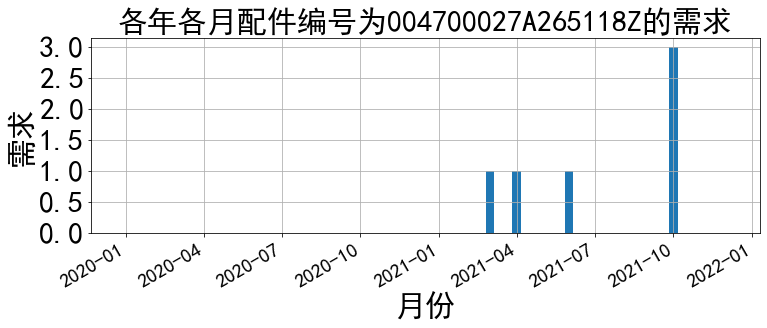

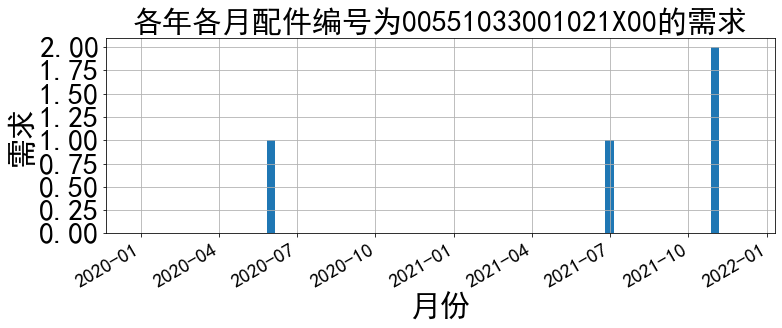

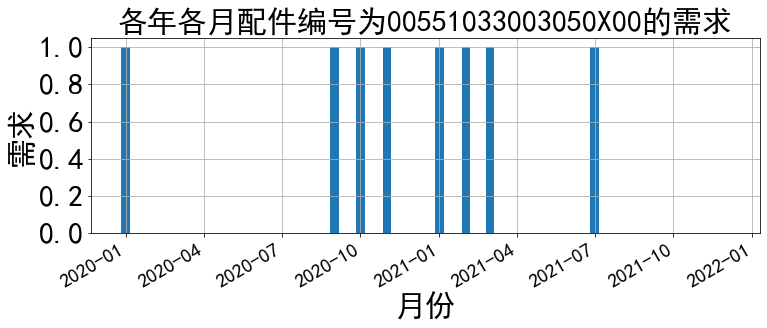

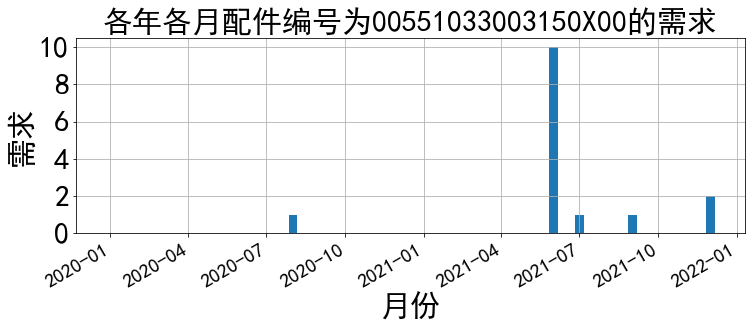

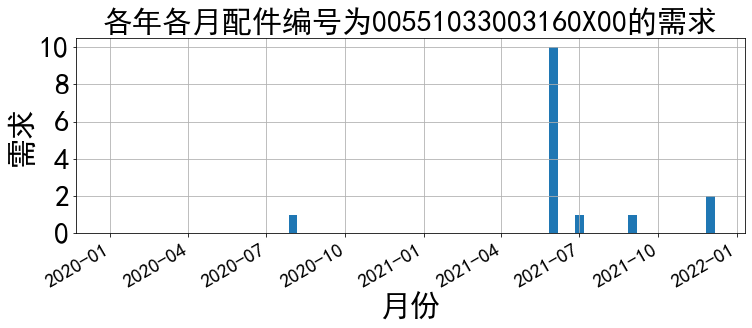

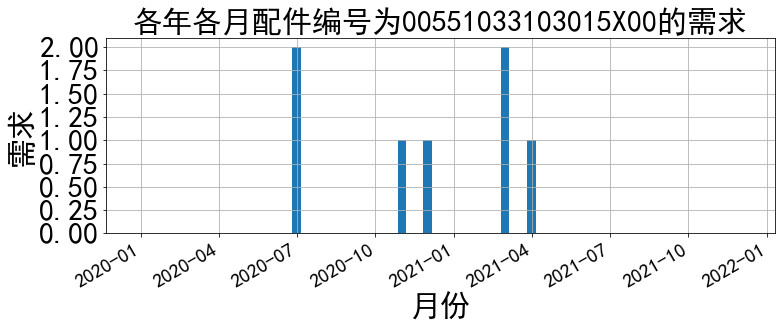

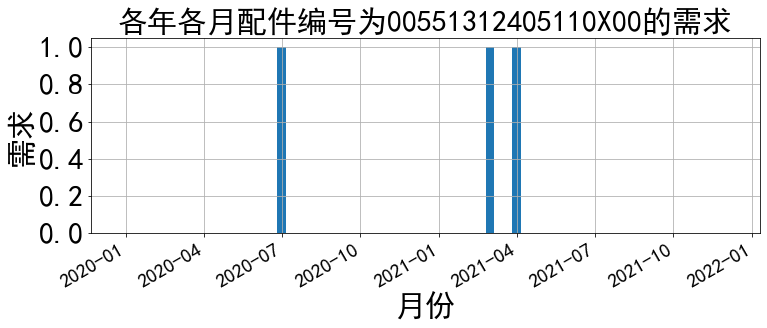

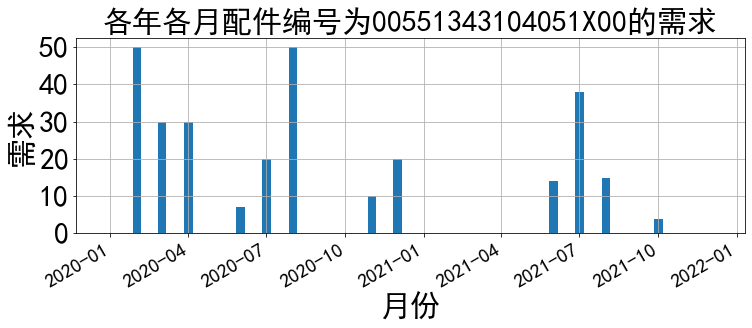

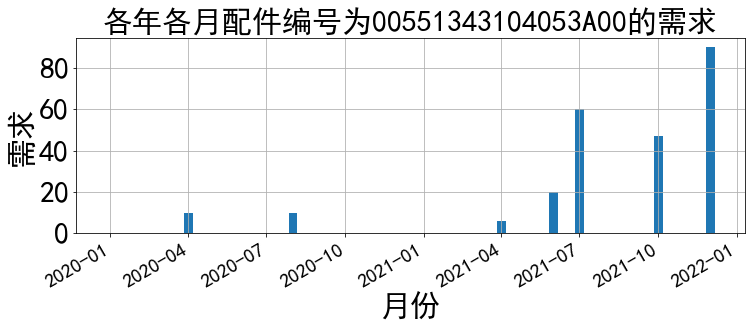

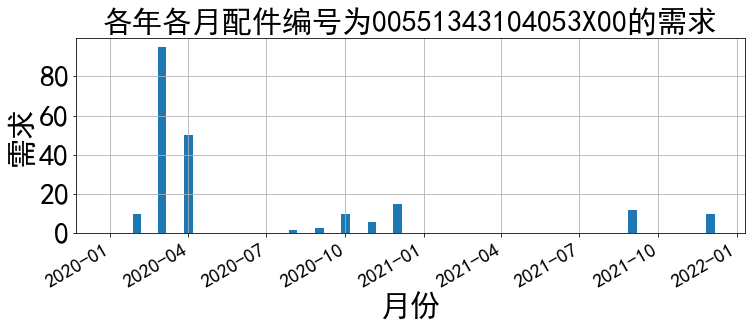

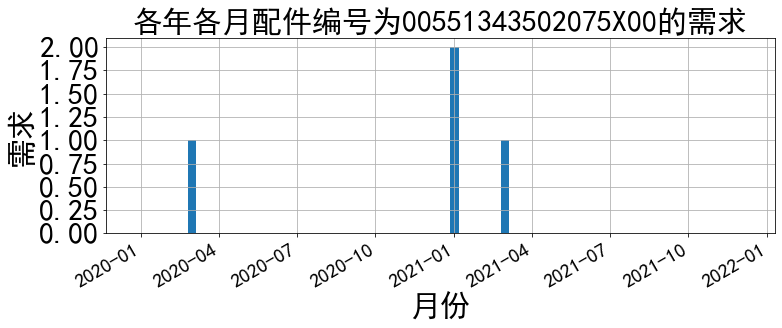

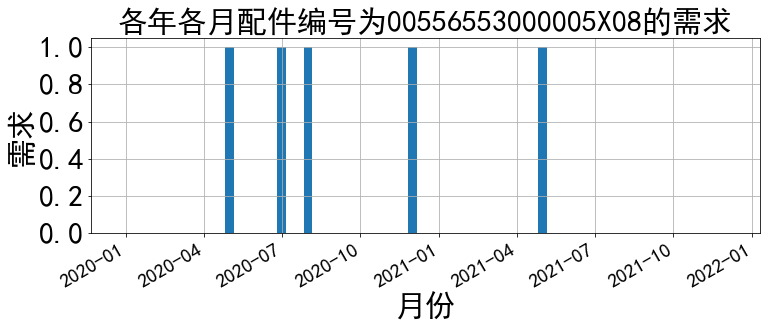

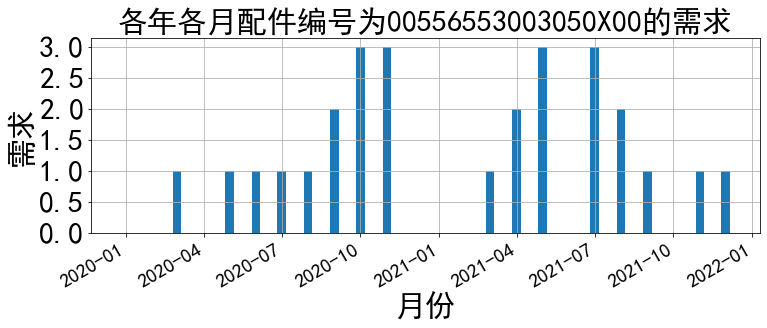

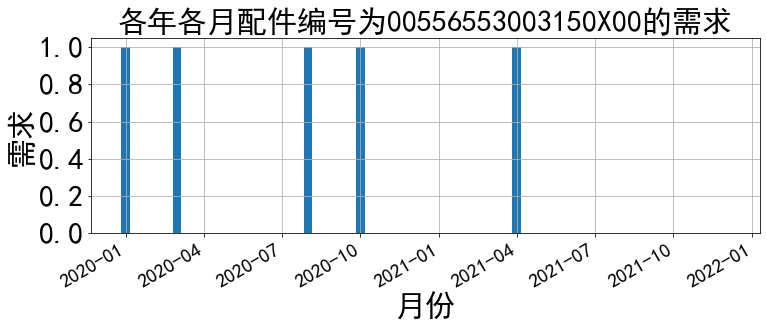

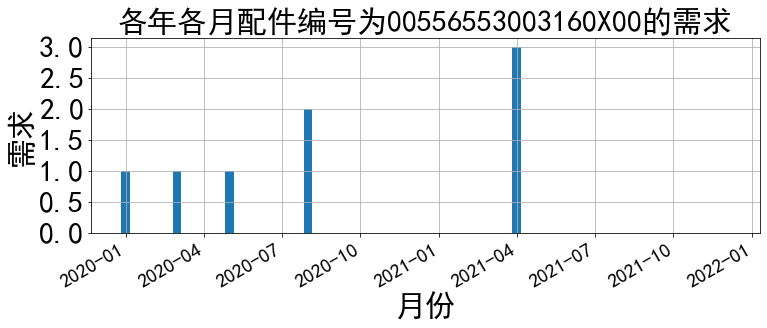

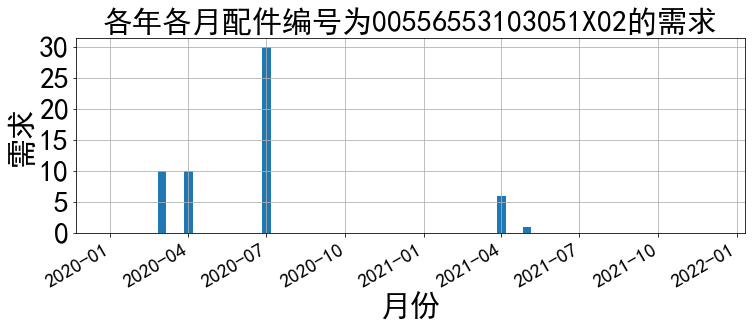

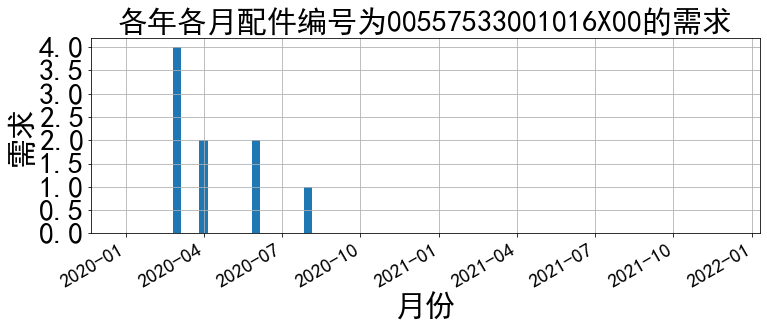

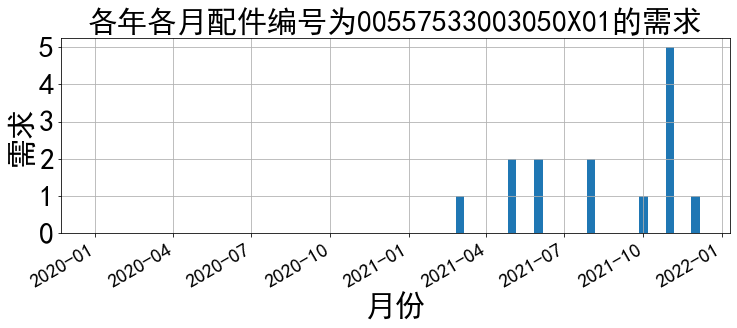

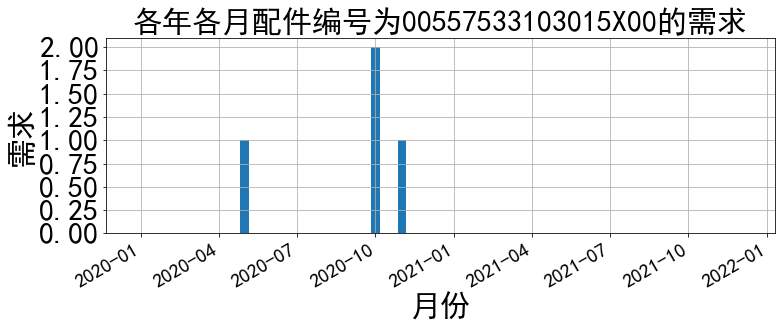

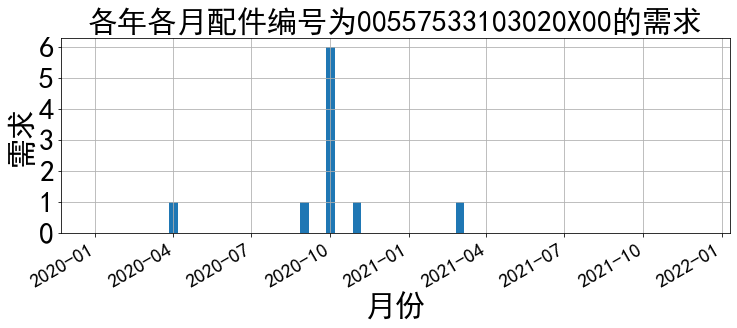

In [31]:
# 可视化
ids = matrl_stats.loc[(matrl_stats['需求平均间隔']<=6), '物料编号'].values
matrl_full['day'] = 1
matrl_full['date'] = pd.to_datetime(matrl_full[['year', 'month', 'day']])
count = 0
for i in ids:
    plot_monthly(matrl_full[matrl_full['物料编号']==i], 
                ylabel='月订单数量', 
                title='各年各月配件编号为'+i+'的需求')
    count = count + 1
    if count==20:
        break

29971


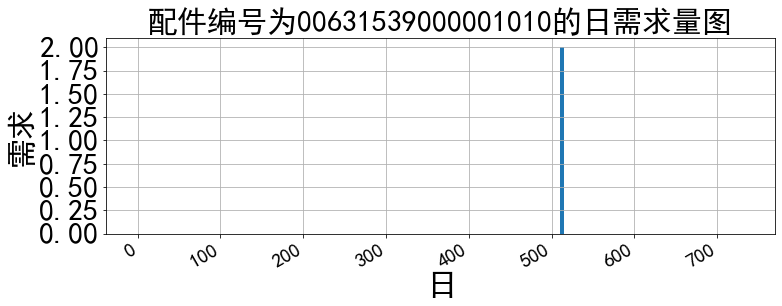

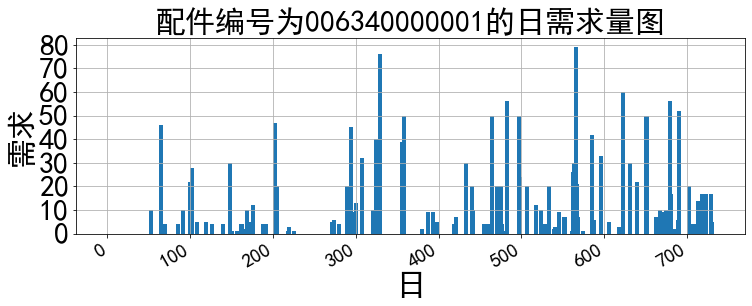

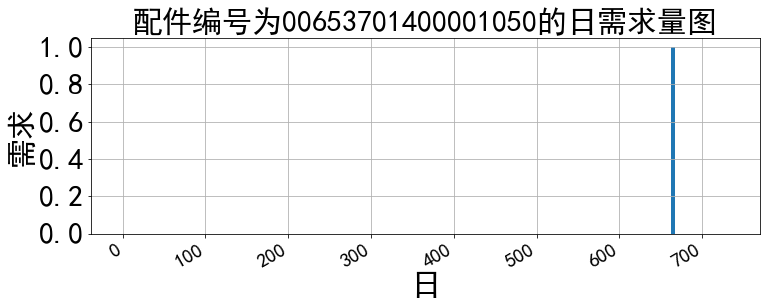

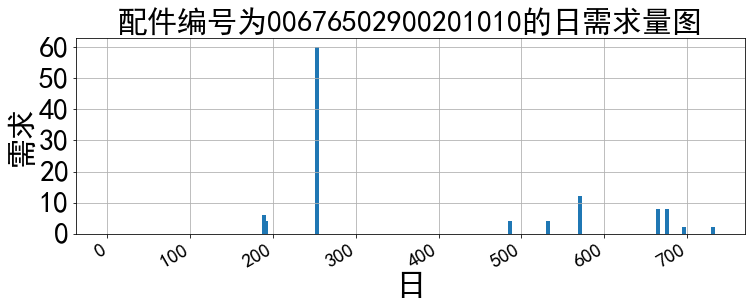

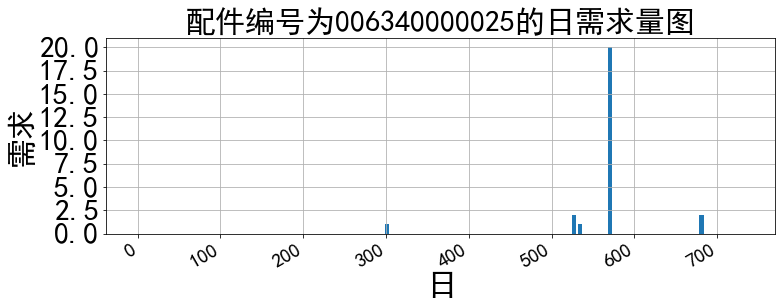

In [10]:
# 取少部分数据，按照日来观察
day_df = df.loc[df['物料类别']=='弹簧件类'].copy()

# 提取该年的第几天
def extract_day(dd):
    dd = datetime.datetime.strptime(dd,"%Y-%m-%d %H:%M:%S")
    return dd.timetuple().tm_yday

# 构造包含完整日的订单数据，没有的日订单数量补0
# 无物料类别信息等业务信息的，补未知
def struct_full_day_df(day_df):
    
    full_day_df = pd.DataFrame(
        product(day_df['物料编号'].unique(), [2020, 2021], range(1,367)), 
        columns=['物料编号', 'year', '年日'])
    drop_index = full_day_df.loc[(full_day_df['year']==2021) & (full_day_df['年日']==366)].index
    full_day_df.drop(drop_index, inplace=True)
    
    temp1 = day_df.groupby(['物料编号', 'year', '年日'], as_index=False)['订单数量'].agg({'日订单数量':'sum'})
    temp2 = day_df.groupby(['物料类别', '物料编号'], as_index=False).count()
    temp3 = day_df.groupby(['基本计量单位', '物料编号'], as_index=False).count()
    temp4 = day_df.groupby(['是否进口件', '物料编号'], as_index=False).count()
    temp5 = day_df.groupby(['周期（天）下计划后的交货周期', '物料编号'], as_index=False).count()
    temp6 = day_df.groupby(['在产情况', '物料编号'], as_index=False).count()
    full_day_df = pd.merge(full_day_df, temp1, on=['物料编号', 'year', '年日'], how='left')
    full_day_df = pd.merge(full_day_df, temp2[['物料类别', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp3[['基本计量单位', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp4[['是否进口件', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp5[['周期（天）下计划后的交货周期', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp6[['在产情况', '物料编号']], on=['物料编号'], how='left')
    full_day_df['日订单数量'].fillna(0, inplace=True)
    full_day_df.fillna('未知', inplace=True)
    full_day_df['日'] = (full_day_df['year'] - 2020) * 366 + full_day_df['年日']
    return full_day_df

def plot_day(data, ylabel='日订单数量', title='各类配件需求总量日订单量图'):
    
    plt.figure(figsize=(12, 4))
    x = data['日']
    y = data[ylabel]
#     plt.plot(x, y)
    plt.bar(x, y, width=5)
    plt.xticks(fontsize=20)    
    plt.yticks(fontsize=30) 
    plt.xlabel('日', fontsize=30)    
    plt.ylabel('需求', fontsize=30)
    plt.title(title, fontsize=30)
    plt.grid()
    plt.gcf().autofmt_xdate() # 自动旋转日期标记
    plt.show()
    

day_df['年日'] = day_df['创建日期'].apply(extract_day)
matrl_full_day = struct_full_day_df(day_df)
print(len(matrl_full_day))

count = 0
for i in matrl_full_day['物料编号'].unique():
    plot_day(matrl_full_day[matrl_full_day['物料编号']==i],
             ylabel='日订单数量', 
             title='配件编号为'+i+'的日需求量图')
    count += 1
    if count==5:
        break